In [17]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import numpy as np
import re

# Agregar el directorio raíz y src/ al sys.path
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(root_path, 'src')
sys.path.append(src_path)

from functions import get_config, get_database_connection, fetch_query_as_dataframe


# Construir la ruta absoluta del archivo config.cfg
config_path = os.path.join(root_path, 'config.cfg')

# Leer configuración
config = get_config(config_path)

# Crear conexión a la base de datos
try:
    engine = get_database_connection(config)
    
    # Ruta del archivo SQL
    sql_file_path = os.path.join(root_path, 'sql/queries/fetch_books.sql')
    
    # Ejecutar la consulta SQL y cargarla en un DataFrame
    #df = fetch_query_as_dataframe(engine, sql_file_path)
    
    # Mostrar estadísticas descriptivas
    #display(df.describe(include='all').T)

    # Save the DataFrame to a CSV file
    # df.to_csv(os.path.join(root_path, 'data/processed', 'books.csv'), index=False)
except ValueError as e:
    print(f"Error: {e}")

# Leer el CSV
df = pd.read_csv('../data/processed/books.csv')

In [18]:
df.shape

(1160, 6)

In [19]:
df.describe(include='all' ).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
book_id,1160.0,NaN,NaN,NaN,22562016.616379,17123992.329878,320.0,7220401.75,21007949.5,34276952.5,199909769.0
book_title,1160,1156,Aquinas,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
authors,796,577,C.S. Lewis,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tag_count,1160.0,NaN,NaN,NaN,6.958621,5.052444,0.0,3.0,6.0,10.0,30.0
tags,1159,918,to-read,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
blurb,1160,1152,This book was converted from its physical edit...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df.head()

,book_id,book_title,authors,tag_count,tags,blurb
0,26872047,Caminando por valles oscuros: Memorias de un j...,Walter J. Ciszek,30,"abandonment-in-god, biography, catholic, chełm...","Walter Ciszek, jesuita norteamericano, entró e..."
1,18968737,The Return of the Prodigal Son: A Story of Hom...,Henri J.M. Nouwen,28,"_pilar, _sindy, abandonment-in-god, anxiety, a...",<p>A chance encounter with a reproduction of R...
2,57132719,Liberado: Una Guía Práctica para la Liberación,Neal Lozano,28,"catholic, chełmińska, christ, christianity, de...","A pesar de nuestros mejores esfuerzos, muchos ..."
3,25239369,El Abandono en la Divina Providencia: Clásicos...,Jean-Pierre de Caussade,27,"abandonment-in-god, catholic, christ, classics...",Esta breve obra se compone de cartas escritas ...
4,40237158,Una familia de bandidos en 1793,NaN,26,"adventures, atheism, biography, catholic, chur...",Resulta difícil no emocionarse varias veces al...


In [21]:
# Veamos coplumna tags
df['tags'].value_counts()

tags
to-read                                                                                                                   49
closed, programming                                                                                                       29
not-interested, ufo                                                                                                       17
biography, to-read                                                                                                        11
closed, science                                                                                                           11
                                                                                                                          ..
allegories, anglicanism, christianity, classics, fiction, literature, miex, quarantine, religion, theology                 1
catholic, classics, devotional, fiction, literature, monks, nuns, spirituality, to-read, women                          

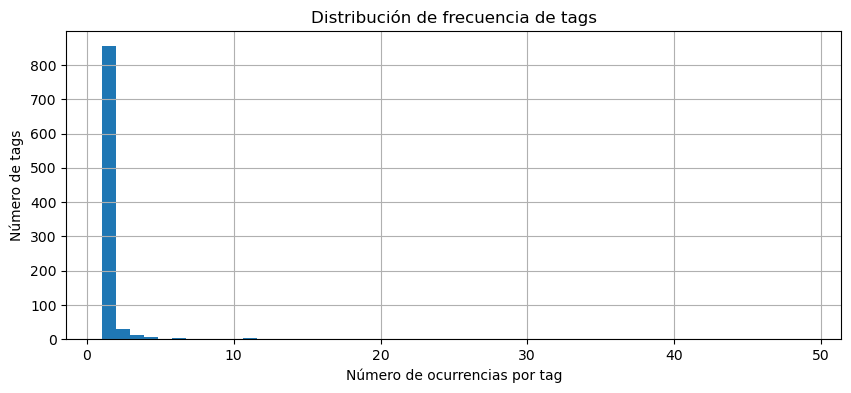

In [22]:
tag_counts = df['tags'].explode().value_counts()

plt.figure(figsize=(10,4))
tag_counts.hist(bins=50)
plt.title('Distribución de frecuencia de tags')
plt.xlabel('Número de ocurrencias por tag')
plt.ylabel('Número de tags')
plt.show()

In [23]:
# Verificamos columnas disponibles
print("Columnas disponibles:", df.columns)

# Usamos la columna 'blurb' como base textual
text_column = 'blurb'
df[text_column] = df[text_column].fillna("")

# Limpieza básica de HTML/tokens tipo <br>, etc.
df[text_column] = df[text_column].apply(lambda x: re.sub(r'<.*?>', ' ', x))

# Vectorizamos el texto
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df[text_column])

# Reducción de dimensionalidad + normalización
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X)
X_normalized = normalize(X_reduced)

# Clustering
n_clusters = 20
n_clusters = 30
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_normalized)
df['cluster'] = clusters

# Lista de stopwords adicionales (inglés, español, tokens basura)
custom_stopwords = set([
    'the', 'and', 'of', 'in', 'to', 'a', 'que', 'la', 'el', 'en', 'de', 'y',
    'los', 'las', 'un', 'una', 'uno', 'por', 'con', 'br', 'book', 'edition', 'html',
    'isbn', 'etc', 'vol', 'volume', 'del', 'al', 'le', 'lo', 'su', 'sus',
    'para', 'como', 'este', 'esta', 'estos', 'estas', 'estas', 'estos', 'entre',
    'sobre', 'hacia', 'desde', 'hasta', 'cual', 'cualquier', 'cualquiera', 'más', 'nos',
    'nosotros', 'nosotras', 'vosotros', 'vosotras', 'ellos', 'ellas', 'ellos', 'ellas',
    'tú', 'ti', 'te', 'ti', 'te', 'os', 'os', 'usted', 'ustedes', 'vos', 'vosotros',
    'vosotras', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo',
    'suya', 'suyos', 'suyas', 'nuest'
    'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras',
    'esos', 'esas', 'esas', 'esos', 'aquel', 'aquella', 'aquellos', 'aquellas', 'ese', 'esa',
    'esos', 'esas', 'esto', 'estos', 'estas', 'esto', 'aquello', 'aquellos', 'aquellas',
    'aquel', 'aquella', 'aquellos', 'aquellas', 'esta', 'estos', 'estas', 'ese',
    'esa', 'esos', 'esas', 'aquel', 'aquella', 'aquellos', 'aquellas', 'éste', 'ésta',
    'éstos', 'éstas', 'ése', 'ésa', 'ésos', 'ésas', 'aquél', 'aquélla', 'aquéllos', 'aquéllas'
])

# Extraer palabra representativa por cluster
top_terms = []
terms = vectorizer.get_feature_names_out()

for i in range(n_clusters):
    center = kmeans.cluster_centers_[i]
    center_original_space = svd.inverse_transform(center.reshape(1, -1)).flatten()
    top_indices = center_original_space.argsort()[::-1]

    top_word = None
    for idx in top_indices:
        candidate = terms[idx]
        if candidate.isalpha() and len(candidate) > 2 and candidate.lower() not in custom_stopwords:
            top_word = candidate
            break

    top_terms.append(top_word if top_word else 'misc')

# Asignar etiquetas a cada cluster
cluster_to_label = {i: top_terms[i] for i in range(n_clusters)}
df['label'] = df['cluster'].map(cluster_to_label)

samples_per_label = 1160 // 6  # 193 libros por categoría
samples_per_label = 100  
samples_per_label = 55  

# Seleccionar las 6 etiquetas más comunes
# top_labels = df['label'].value_counts().nlargest(6).index.tolist()
# df_filtered = df[df['label'].isin(top_labels)].copy()

# Seleccionar las etiquetas que tienen al menos `samples_per_label` ejemplos
label_counts = df['label'].value_counts()
eligible_labels = label_counts[label_counts >= samples_per_label].index.tolist()

# Limitar a 6 si hay más de 6
top_labels = eligible_labels[:6]
df_filtered = df[df['label'].isin(top_labels)].copy()

print(f"Etiquetas seleccionadas: {top_labels}")

# Balancear las categorías
balanced_rows = []

for label in top_labels:
    rows = df_filtered[df_filtered['label'] == label]
    if len(rows) >= samples_per_label:
        sampled = rows.sample(samples_per_label, random_state=42)
        balanced_rows.append(sampled)
    else:
        print(f"Advertencia: la etiqueta '{label}' no tiene suficientes ejemplos.")

# Combinar resultados
final_df = pd.concat(balanced_rows).reset_index(drop=True)
final_df['category'] = final_df['label']

# Mostrar distribución final
print("Distribución balanceada:")
print(final_df['category'].value_counts())

# Guardar a CSV (opcional)
# final_df.to_csv('books_with_balanced_categories.csv', index=False)

# Mostrar ejemplos
final_df[['book_title', 'category', 'blurb']].head()


Columnas disponibles: Index(['book_id', 'book_title', 'authors', 'tag_count', 'tags', 'blurb'], dtype='object')
Etiquetas seleccionadas: ['work', 'vida', 'dios', 'jesus', 'life', 'autor']
Distribución balanceada:
category
work     55
vida     55
dios     55
jesus    55
life     55
autor    55
Name: count, dtype: int64


c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


,book_title,category,blurb
0,Sobre la muerte y los moribundos: Una lección ...,work,Written by Dr. Elisabeth Kübler--Ross this boo...
1,Fascinating Womanhood: Vintage Edition,work,Fascinating Womanhood is proud to introduce th...
2,Color Atlas of Pharmacology,work,Updated with the most important new substances...
3,The Poetics of Space,work,Since its first publication in English in 1964...
4,"Dali the Paintings: Volume I, 1904-1946; Volum...",work,This publication presents the entire painted o...


In [24]:
final_df['category'].value_counts()

category
work     55
vida     55
dios     55
jesus    55
life     55
autor    55
Name: count, dtype: int64

In [26]:
min_samples = samples_per_label
label_counts = df['label'].value_counts()
eligible_labels = label_counts[label_counts >= min_samples].index.tolist()[:6]

eligible_labels


['work', 'vida', 'dios', 'jesus', 'life', 'autor']

In [27]:
# todas las etiquetas disponibles ordenadas por frecuencia
print(df['label'].value_counts())


label
work          183
vida          158
dios          127
jesus          89
life           63
autor          58
god            54
world          48
catholic       41
philosophy     36
spiritual      35
mary           34
pope           30
science        27
war            26
saint          21
prayer         20
bible          18
software       18
ufo            16
une            13
universe       11
uma             9
version         8
smurf           8
spanish         5
delivery        4
Name: count, dtype: int64


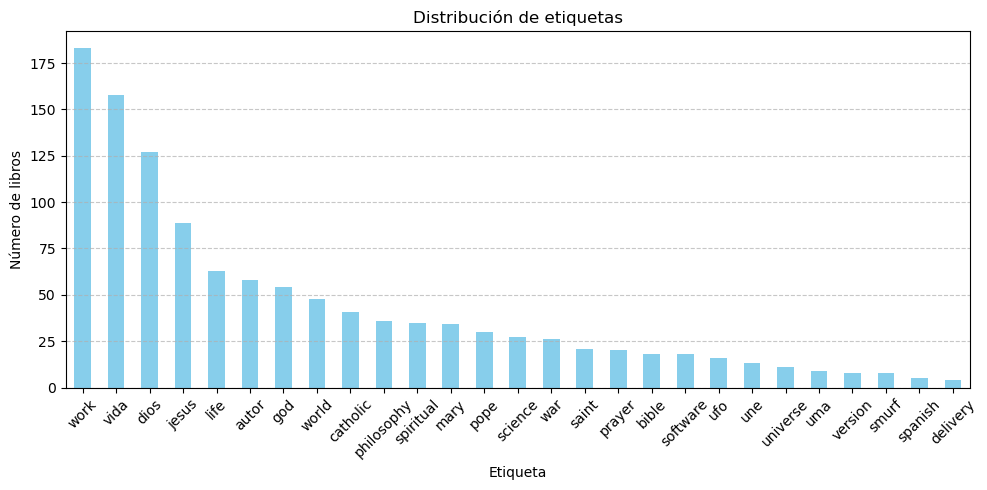

In [40]:
# Plotear la distribución de etiquetas con sus porcentajes y grid
plt.figure(figsize=(10, 5))
df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribución de etiquetas')
plt.xlabel('Etiqueta')
plt.ylabel('Número de libros')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# Guardar la figura
plt.savefig('../img/tag_distribution.jpg', dpi=300, bbox_inches='tight')
plt.show()



In [35]:
print(df['label'].value_counts()[df['label'].value_counts() > 50])


label
work     183
vida     158
dios     127
jesus     89
life      63
autor     58
god       54
Name: count, dtype: int64
